<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Higgs_Boson_QMAML_Classification%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Download and unzip the Higgs dataset, install dependencies
!wget -O HIGGS.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gunzip HIGGS.csv.gz
!pip install pennylane --quiet

--2025-06-11 13:19:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [            <=>     ]   2.62G  79.4MB/s    in 46s     

2025-06-11 13:20:33 (57.9 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [43]:
CSV_PATH = 'HIGGS.csv'

In [44]:
N_TRAIN = 2000         # More training data, but still manageable
N_TEST = 500
N_FEATURES = 8         # Keep this small for quantum speed
N_CLASSES = 2

# PQC/QNN
N_QUBITS = 6           # Slightly more qubits, but not too many
PQC_LAYERS = 2         # Two layers for more expressivity

# Meta-initializer MLP
META_INIT_HIDDEN = 32  # Slightly wider

# Training
BATCH_SIZE = 32
N_EPOCHS = 10          # More epochs for better learning
LR = 0.01

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [45]:
# 3. Dataset (use only first N_FEATURES for quantum speed)
class HiggsDataset(Dataset):
    def __init__(self, csv_path, n_samples=None, offset=0):
        df = pd.read_csv(csv_path, header=None, nrows=n_samples, skiprows=range(1, offset+1))
        X = df.iloc[:, 1:].values.astype(np.float32)[:, :N_FEATURES]
        self.X = X
        self.y = df.iloc[:, 0].values.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [46]:
# 4. Task embedding and meta-initializer MLP
def task_embedding(task_id, n_qubits=N_QUBITS):
    # Simple: one-hot or random vector for each task
    emb = torch.zeros(n_qubits)
    emb[task_id % n_qubits] = 1.0
    return emb

class MetaInitializerMLP(nn.Module):
    def __init__(self, emb_dim, pqc_layers, n_qubits):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, META_INIT_HIDDEN),
            nn.ReLU(),
            nn.Linear(META_INIT_HIDDEN, pqc_layers * n_qubits * 2)
        )
        self.pqc_layers = pqc_layers
        self.n_qubits = n_qubits
    def forward(self, emb):
        out = self.mlp(emb)
        return out.view(self.pqc_layers, self.n_qubits, 2)

In [47]:
# 5. PQC/QNN classifier
dev = qml.device("default.qubit", wires=N_QUBITS)

def angle_encode(x):
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def pqc_classifier(weights, x):
    angle_encode(x)
    for l in range(weights.shape[0]):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))  # Use qubit 0 for binary classification

In [48]:
def train_meta_qnn(train_dataset, n_epochs, batch_size, device):
    meta_init = MetaInitializerMLP(N_QUBITS, PQC_LAYERS, N_QUBITS).to(device)
    optimizer = optim.Adam(meta_init.parameters(), lr=LR)
    losses, accs, f1s, rocs = [], [], [], []
    for epoch in range(n_epochs):
        meta_init.train()
        total_loss = 0
        all_preds, all_trues = [], []
        for i in range(0, len(train_dataset), batch_size):
            X_batch = torch.stack([train_dataset[j][0] for j in range(i, min(i+batch_size, len(train_dataset)))])
            y_batch = torch.tensor([train_dataset[j][1] for j in range(i, min(i+batch_size, len(train_dataset)))])
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            emb = task_embedding(0).to(device)
            pqc_params = meta_init(emb)
            preds = torch.stack([pqc_classifier(pqc_params, x) for x in X_batch])
            preds = preds.float()
            preds = (preds + 1) / 2
            y_batch = y_batch.float()
            loss = nn.BCELoss()(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(y_batch.cpu().numpy())
        avg_loss = total_loss / len(train_dataset)
        pred_labels = (np.array(all_preds) > 0.5).astype(int)
        acc = accuracy_score(all_trues, pred_labels)
        f1 = f1_score(all_trues, pred_labels)
        try:
            roc = roc_auc_score(all_trues, all_preds)
        except:
            roc = float('nan')
        losses.append(avg_loss)
        accs.append(acc)
        f1s.append(f1)
        rocs.append(roc)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Acc {acc:.4f}, F1 {f1:.4f}, ROC-AUC {roc:.4f}")
    return meta_init, losses, accs, f1s, rocs

In [49]:
def eval_meta_qnn(meta_init, test_dataset, device):
    meta_init.eval()
    emb = task_embedding(0).to(device)
    pqc_params = meta_init(emb)
    preds, trues = [], []
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        x = x.to(device)
        pred = pqc_classifier(pqc_params, x)
        pred = (pred.item() + 1) / 2
        preds.append(pred)
        trues.append(y)
    preds = np.array(preds)
    trues = np.array(trues)
    pred_labels = (preds > 0.5).astype(int)
    acc = accuracy_score(trues, pred_labels)
    f1 = f1_score(trues, pred_labels)
    try:
        roc = roc_auc_score(trues, preds)
    except:
        roc = float('nan')
    print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    return preds, trues

cuda
Loading data...
Training meta-initializer + PQC classifier...
Epoch 1: Loss 0.7272, Acc 0.5360, F1 0.5897, ROC-AUC 0.5380
Epoch 2: Loss 0.6954, Acc 0.5125, F1 0.5594, ROC-AUC 0.5119
Epoch 3: Loss 0.6957, Acc 0.5080, F1 0.5619, ROC-AUC 0.5045
Epoch 4: Loss 0.6948, Acc 0.5225, F1 0.5992, ROC-AUC 0.5131
Epoch 5: Loss 0.6943, Acc 0.5270, F1 0.6081, ROC-AUC 0.5256
Epoch 6: Loss 0.6950, Acc 0.5230, F1 0.6051, ROC-AUC 0.5211
Epoch 7: Loss 0.6941, Acc 0.5235, F1 0.6067, ROC-AUC 0.5266
Epoch 8: Loss 0.6949, Acc 0.5255, F1 0.6119, ROC-AUC 0.5202
Epoch 9: Loss 0.6943, Acc 0.5270, F1 0.6120, ROC-AUC 0.5251
Epoch 10: Loss 0.6946, Acc 0.5155, F1 0.6047, ROC-AUC 0.5204


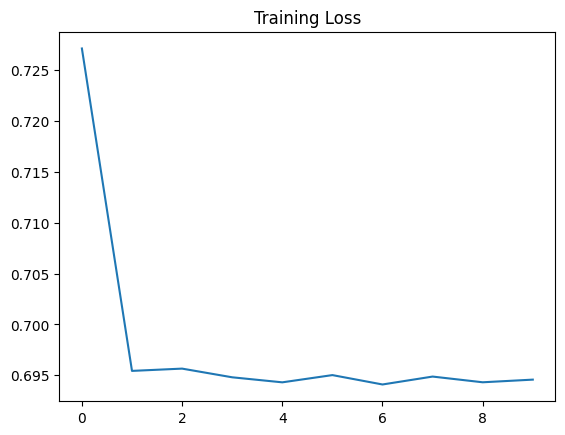

Evaluating...
Test Accuracy: 0.5400, F1: 0.6637, ROC-AUC: 0.4959


(array([0.5232492 , 0.57168311, 0.56121676, 0.50176545, 0.49629407,
        0.47120288, 0.5479107 , 0.570385  , 0.59406779, 0.45054338,
        0.56660201, 0.52920395, 0.59729249, 0.44100078, 0.48441065,
        0.57776932, 0.56404746, 0.58603542, 0.60666376, 0.59941285,
        0.60198463, 0.52206011, 0.56831857, 0.58905772, 0.53684915,
        0.51352707, 0.47414588, 0.54770752, 0.60296521, 0.55238888,
        0.49877541, 0.59112202, 0.51503679, 0.58039873, 0.60176928,
        0.60314364, 0.60005419, 0.53784017, 0.56482216, 0.45982146,
        0.60517773, 0.49580948, 0.5148418 , 0.59963248, 0.48576558,
        0.50140721, 0.51777225, 0.60892094, 0.60646136, 0.49617445,
        0.59055984, 0.60115574, 0.49443451, 0.49047912, 0.60094966,
        0.57396084, 0.60298056, 0.59155188, 0.58954721, 0.61415118,
        0.55920019, 0.55595905, 0.55012556, 0.57996346, 0.49885609,
        0.5309071 , 0.61229219, 0.51134488, 0.56199485, 0.58019577,
        0.57904299, 0.60668295, 0.59856622, 0.54

In [50]:
# 8. Run the pipeline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print("Loading data...")
train_dataset = HiggsDataset(CSV_PATH, n_samples=N_TRAIN)
test_dataset = HiggsDataset(CSV_PATH, n_samples=N_TEST, offset=N_TRAIN)
print("Training meta-initializer + PQC classifier...")
meta_init, losses, accs, f1s, rocs = train_meta_qnn(train_dataset, N_EPOCHS, BATCH_SIZE, device)
plt.plot(losses)
plt.title("Training Loss")
plt.show()
print("Evaluating...")
eval_meta_qnn(meta_init, test_dataset, device)

In [ ]:
# After training:
meta_init, losses, accs, f1s, rocs = train_meta_qnn(train_dataset, N_EPOCHS, BATCH_SIZE, device)
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.plot(losses); plt.title("Loss")
plt.subplot(1,4,2); plt.plot(accs); plt.title("Accuracy")
plt.subplot(1,4,3); plt.plot(f1s); plt.title("F1")
plt.subplot(1,4,4); plt.plot(rocs); plt.title("ROC-AUC")
plt.tight_layout(); plt.show()